In [1]:
import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt
import os
import tensorflow.contrib.slim as slim
from scipy.misc import imread, imresize
from tensorflow.examples.tutorials.mnist import input_data

%matplotlib inline
print('tensorflow version is : ',tf.__version__)

tensorflow version is :  1.2.1


# Download MNIST Dataset

In [2]:
mnist = input_data.read_data_sets('./data/mnist', one_hot=True) # download

Extracting ./data/mnist\train-images-idx3-ubyte.gz
Extracting ./data/mnist\train-labels-idx1-ubyte.gz
Extracting ./data/mnist\t10k-images-idx3-ubyte.gz
Extracting ./data/mnist\t10k-labels-idx1-ubyte.gz


# Define functions

In [3]:
def get_session():
    config = tf.ConfigProto()
    config.allow_soft_placement=True
    config.gpu_options.allow_growth = False
    config.log_device_placement=False
    sess = tf.Session(config = config)
    
    return sess
    
def make_noise(batch_size, noise_size):
    return np.random.randn(batch_size, noise_size)    
    
def lrelu(x, leak=0.2, name="lrelu"):
    return tf.maximum(x, leak*x)

    

def generator(Z, layer1, layer2, name = 'Generator'):
    with tf.variable_scope(name):
        fn = tf.nn.relu
        L1 = tf.layers.dense(Z, layer1, activation = fn)
        L2 = tf.layers.dense(L1, layer2, activation = fn)
        L3 = tf.layers.dense(L2, 784, activation = fn)
        
        return L3
    
def discriminator(Z, layer1, layer2, name = 'Discriminator', reuse = None):
    with tf.variable_scope(name) as disc:
        if reuse:
            disc.reuse_variables()
            
        fn = tf.nn.relu
        L1 = tf.layers.dense(Z, layer1, activation = fn)
        L2 = tf.layers.dense(L1, layer2, activation = fn)
        L3 = tf.layers.dense(L2, 1, activation = None)
        
        return L3
    
def generator_conv(Z, feat_map1, feat_map2, filter_size, is_training = True, name = 'Generator_conv'):
    with tf.variable_scope(name):
       
        L1 = slim.fully_connected(Z, 1024, activation_fn = tf.nn.relu, 
                                   weights_initializer = slim.xavier_initializer(), normalizer_fn = slim.batch_norm, normalizer_params = {'is_training' : is_training})
        
        L2 = slim.fully_connected(L1, 7*7*128, activation_fn = tf.nn.relu, 
                                   weights_initializer = slim.xavier_initializer(), normalizer_fn = slim.batch_norm, normalizer_params = {'is_training' : is_training})
        L2 = tf.reshape(L2, [-1,7,7,128])
        L3 = slim.conv2d_transpose(L2, feat_map1,filter_size,stride = 2, padding = 'SAME', activation_fn = tf.nn.relu, 
                                   weights_initializer = slim.xavier_initializer(), normalizer_fn = slim.batch_norm, normalizer_params = {'is_training' : is_training}, scope = 'slim_conv_transpose1')
        L4 = slim.conv2d_transpose(L3, feat_map2,filter_size,stride = 2, padding = 'SAME', activation_fn = tf.nn.sigmoid, 
                                   weights_initializer =slim.xavier_initializer() ,scope = 'slim_conv_transpose2')
        L4 = tf.reshape(L4, [-1,784])
        return L4
    
def discriminator_conv(Z, feat_map1,feat_map2, filter_size, is_training=True, name = 'Discriminator_conv', reuse = None):
    with tf.variable_scope(name) as disc:
        if reuse:
            disc.reuse_variables()
        
        init = slim.xavier_initializer()
        fn = lrelu
        Z = tf.reshape(Z, [-1, 28, 28, 1]) # transter to 4dim in slim
        
        L1 = slim.conv2d(Z, feat_map1,filter_size, padding = 'SAME', activation_fn = fn, weights_initializer = init,
                         normalizer_fn = slim.batch_norm,normalizer_params = {'is_training' : is_training}, scope = 'slim_conv1')
        
        L2 = slim.conv2d(L1, feat_map2,filter_size, padding = 'SAME', activation_fn = fn, weights_initializer = init,
                         normalizer_fn = slim.batch_norm, normalizer_params = {'is_training' : is_training},scope = 'slim_conv2')
        
        L2 = slim.flatten(L2, scope = 'flatten_slim_layer')
        
        L3 = slim.fully_connected(L2, 1, activation_fn = None)
        

        
        return L3
    
def loss_gan(D_real, D_fake):
    loss_real = tf.reduce_mean(tf.nn.sigmoid_cross_entropy_with_logits(logits = D_real, 
                                                                           labels = tf.ones_like(D_real)))
    loss_fake = tf.reduce_mean(tf.nn.sigmoid_cross_entropy_with_logits(logits = D_fake, 
                                                                           labels = tf.zeros_like(D_fake)))
    loss_G = tf.reduce_mean(tf.nn.sigmoid_cross_entropy_with_logits(logits = D_fake, 
                                                                           labels = tf.ones_like(D_fake)))
    return loss_real + loss_fake, loss_G


def loss_lsgan(D_real, D_fake):
    loss_D = tf.reduce_mean(tf.square(D_real - 1) + tf.square(D_fake))*0.5
             
    loss_G = tf.reduce_mean(tf.square(D_fake - 1))*0.5
    return loss_D, loss_G


def display(sess, G, noise,fig_num=5):
    
 
    images = sess.run(G, feed_dict = {Z:noise, is_training : False})

    fig = plt.figure()
    for i in range(fig_num):
        snap = fig.add_subplot(1, fig_num, i+1)
        snap.set_xticks([])
        snap.set_yticks([])
        plt.imshow(images[i].reshape([28, 28]), cmap = 'gray')
    plt.show()

# Hyperparameter Settings

In [4]:
batch_size = 100
noise_size = 128

epoch = 101

learning_rate = 0.001

# VanillaGAN setting

In [5]:
X = tf.placeholder(tf.float32, [None, 784])
Z = tf.placeholder(tf.float32, [None, noise_size])
is_training = tf.placeholder(tf.bool)

G = generator(Z, 128, 128)
D_real = discriminator(X, 128, 128)
D_fake = discriminator(G, 128, 128, reuse = True)

loss_D, loss_G = loss_gan(D_real, D_fake)

g_vars = tf.get_collection(tf.GraphKeys.TRAINABLE_VARIABLES, scope = 'Generator')
d_vars = tf.get_collection(tf.GraphKeys.TRAINABLE_VARIABLES, scope = 'Discriminator')


d_optimizer = tf.train.AdamOptimizer(learning_rate = learning_rate/2)
g_optimizer = tf.train.AdamOptimizer(learning_rate = learning_rate)

d_grad = d_optimizer.compute_gradients(loss_D, d_vars)
g_grad = g_optimizer.compute_gradients(loss_G, g_vars)

update_d = d_optimizer.apply_gradients(d_grad)
update_g = g_optimizer.apply_gradients(g_grad)

# Train VanillaGAN

Epoch : 0, D_loss = 0.0806, G_loss = 5.3763


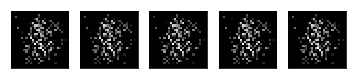

Epoch : 10, D_loss = 0.3172, G_loss = 3.4449


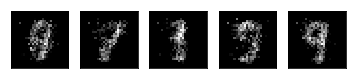

Epoch : 20, D_loss = 0.6649, G_loss = 2.0875


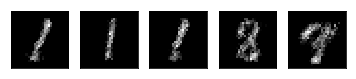

Epoch : 30, D_loss = 0.7613, G_loss = 2.0228


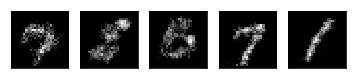

Epoch : 40, D_loss = 0.8558, G_loss = 2.0504


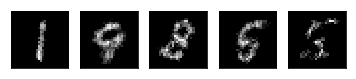

Epoch : 50, D_loss = 0.7370, G_loss = 1.7724


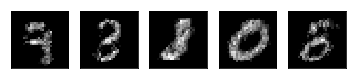

Epoch : 60, D_loss = 0.9481, G_loss = 1.7416


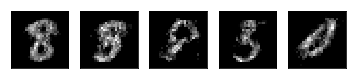

Epoch : 70, D_loss = 0.8346, G_loss = 1.8401


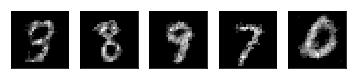

Epoch : 80, D_loss = 0.8773, G_loss = 1.8296


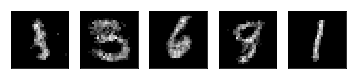

Epoch : 90, D_loss = 0.8663, G_loss = 1.8836


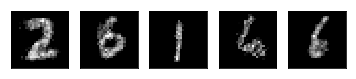

Epoch : 100, D_loss = 0.7499, G_loss = 1.9866


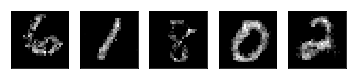

In [6]:
with get_session() as sess:
    init = tf.global_variables_initializer()
    sess.run(init)
    
    for step in range(epoch):
        loss_val_D, loss_val_G = 0,0
        total_batch = int(mnist.train.num_examples/batch_size)
        
        for i in range(total_batch):
            batch_xs, batch_ys = mnist.train.next_batch(batch_size)
            noise_z = make_noise(batch_size, noise_size)
            
            
            _, loss_val_D = sess.run([update_d, loss_D], feed_dict = {X:batch_xs
                                                                       , Z:noise_z})
            _, loss_val_G = sess.run([update_g, loss_G], feed_dict = {Z:noise_z})
        
        
        if step%10==0:
            print('Epoch : {}, D_loss = {:.4f}, G_loss = {:.4f}'.format(step, loss_val_D, loss_val_G))
            z = make_noise(5, noise_size)
            display(sess, G, z)

# Least Squares GAN(LSGAN) setting

In [7]:
loss_D, loss_G = loss_lsgan(D_real, D_fake)

g_vars = tf.get_collection(tf.GraphKeys.TRAINABLE_VARIABLES, scope = 'Generator')
d_vars = tf.get_collection(tf.GraphKeys.TRAINABLE_VARIABLES, scope = 'Discriminator')


d_optimizer = tf.train.AdamOptimizer(learning_rate = learning_rate/2)
g_optimizer = tf.train.AdamOptimizer(learning_rate = learning_rate)

d_grad = d_optimizer.compute_gradients(loss_D, d_vars)
g_grad = g_optimizer.compute_gradients(loss_G, g_vars)

update_d = d_optimizer.apply_gradients(d_grad)
update_g = g_optimizer.apply_gradients(g_grad)

# Train LSGAN

Epoch : 0, D_loss = 0.0142, G_loss = 0.6211


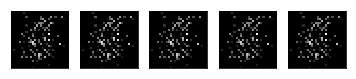

Epoch : 10, D_loss = 0.0440, G_loss = 0.4294


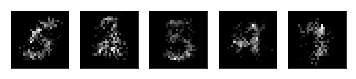

Epoch : 20, D_loss = 0.0723, G_loss = 0.4042


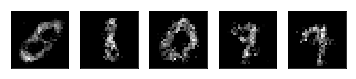

Epoch : 30, D_loss = 0.1232, G_loss = 0.3522


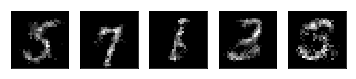

Epoch : 40, D_loss = 0.1356, G_loss = 0.3135


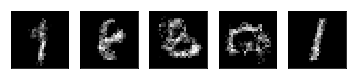

Epoch : 50, D_loss = 0.1266, G_loss = 0.3193


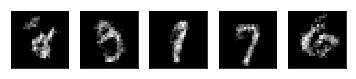

Epoch : 60, D_loss = 0.1603, G_loss = 0.2656


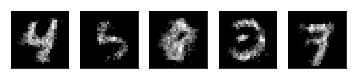

Epoch : 70, D_loss = 0.1277, G_loss = 0.2944


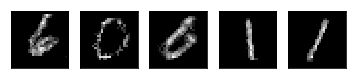

Epoch : 80, D_loss = 0.1371, G_loss = 0.3040


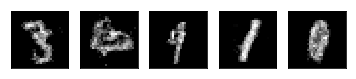

Epoch : 90, D_loss = 0.1344, G_loss = 0.2831


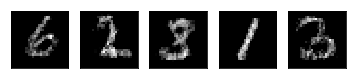

Epoch : 100, D_loss = 0.1440, G_loss = 0.2780


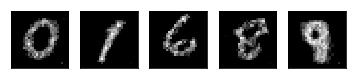

In [8]:
with get_session() as sess:
    init = tf.global_variables_initializer()
    sess.run(init)
    
    for step in range(epoch):
        loss_val_D, loss_val_G = 0,0
        total_batch = int(mnist.train.num_examples/batch_size)
        
        for i in range(total_batch):
            batch_xs, batch_ys = mnist.train.next_batch(batch_size)
            noise_z = make_noise(batch_size, noise_size)
            
            
            _, loss_val_D = sess.run([update_d, loss_D], feed_dict = {X:batch_xs
                                                                       , Z:noise_z})
            _, loss_val_G = sess.run([update_g, loss_G], feed_dict = {Z:noise_z})
        
        
        if step%10==0:
            print('Epoch : {}, D_loss = {:.4f}, G_loss = {:.4f}'.format(step, loss_val_D, loss_val_G))
            z = make_noise(5, noise_size)
            display(sess, G, z)

# Deep Convolutional GAN(DCGAN) with least squares loss

In [9]:
G = generator_conv(Z, 64, 1, [3,3])
D_real = discriminator_conv(X, 32, 64, [5,5])
D_fake = discriminator_conv(G, 32, 64, [5,5], reuse = True)

loss_D, loss_G = loss_lsgan(D_real, D_fake)

g_vars = tf.get_collection(tf.GraphKeys.TRAINABLE_VARIABLES, scope = 'Generator')
d_vars = tf.get_collection(tf.GraphKeys.TRAINABLE_VARIABLES, scope = 'Discriminator')


d_optimizer = tf.train.AdamOptimizer(learning_rate = learning_rate)
g_optimizer = tf.train.AdamOptimizer(learning_rate = learning_rate)

d_grad = d_optimizer.compute_gradients(loss_D, d_vars)
g_grad = g_optimizer.compute_gradients(loss_G, g_vars)

update_d = d_optimizer.apply_gradients(d_grad)
update_g = g_optimizer.apply_gradients(g_grad)

# Train DCGAN with least suqares loss

Epoch : 0, D_loss = 0.0932, G_loss = 0.2709


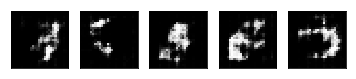

Epoch : 10, D_loss = 0.1912, G_loss = 0.2128


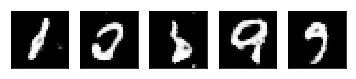

Epoch : 20, D_loss = 0.3985, G_loss = 0.9765


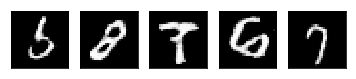

Epoch : 30, D_loss = 0.1965, G_loss = 0.3444


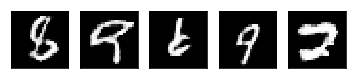

Epoch : 40, D_loss = 0.2472, G_loss = 0.3416


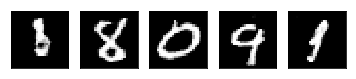

Epoch : 50, D_loss = 0.3663, G_loss = 0.2113


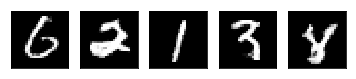

Epoch : 60, D_loss = 0.1837, G_loss = 0.2399


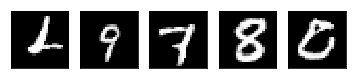

Epoch : 70, D_loss = 0.3424, G_loss = 0.3373


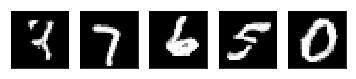

Epoch : 80, D_loss = 0.2584, G_loss = 0.2266


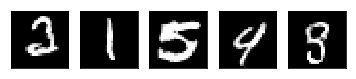

Epoch : 90, D_loss = 0.4214, G_loss = 0.3093


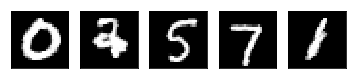

Epoch : 100, D_loss = 0.2701, G_loss = 0.1243


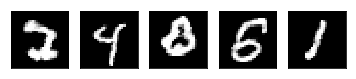

In [10]:
with get_session() as sess:
    init = tf.global_variables_initializer()
    sess.run(init)
    
    for step in range(epoch):
        loss_val_D, loss_val_G = 0,0
        total_batch = int(mnist.train.num_examples/batch_size)
        
        for i in range(total_batch):
            batch_xs, batch_ys = mnist.train.next_batch(batch_size)
            noise_z = make_noise(batch_size, noise_size)
            

            _, loss_val_D = sess.run([update_d, loss_D], feed_dict = {X:batch_xs
                                                                       , Z:noise_z, is_training:True})
            _, loss_val_G = sess.run([update_g, loss_G], feed_dict = {Z:noise_z, is_training:True})
     
        
        if step%10==0:
            print('Epoch : {}, D_loss = {:.4f}, G_loss = {:.4f}'.format(step, loss_val_D, loss_val_G))
            z = make_noise(5, noise_size)
            display(sess, G, z)